In [171]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score

In [313]:
file_path = os.path.join(os.getcwd(), '../data/data.csv')

df = pd.read_csv(file_path)

print(df.shape)
print(df.head())


(5514, 8)
        mode        b1      b2     b3       r1              r2      r3  y
0   knockout    BARLEY   PIPER   RICO     GENE  LARRY & LAWRIE    TICK  1
1     bounty     BELLE    CARL   GENE     GRAY            NANI     R-T  1
2    hotZone       BEA  JESSIE    STU    AMBER          BARLEY    NITA  1
3    gemGrab  DYNAMIKE    FANG  PEARL  CHESTER            GENE  MORTIS  1
4  brawlBall      BUZZ  CLANCY   NITA   BUSTER           BYRON   SANDY  0


In [314]:
names = pd.unique(df[['b1', 'b2', 'b3', 'r1', 'r2', 'r3']].values.ravel())
names.sort()

# print(len(names))
print(names)

modes = pd.unique(df[['mode']].values.ravel())
modes.sort()

# print(len(modes))
print(modes)

['8-BIT' 'AMBER' 'ANGELO' 'ASH' 'BARLEY' 'BEA' 'BELLE' 'BERRY' 'BIBI' 'BO'
 'BONNIE' 'BROCK' 'BULL' 'BUSTER' 'BUZZ' 'BYRON' 'CARL' 'CHARLIE'
 'CHESTER' 'CHUCK' 'CLANCY' 'COLETTE' 'COLT' 'CORDELIUS' 'CROW' 'DARRYL'
 'DOUG' 'DRACO' 'DYNAMIKE' 'EDGAR' 'EL PRIMO' 'EMZ' 'EVE' 'FANG' 'FRANK'
 'GALE' 'GENE' 'GRAY' 'GRIFF' 'GROM' 'GUS' 'HANK' 'JACKY' 'JANET' 'JESSIE'
 'KIT' 'LARRY & LAWRIE' 'LEON' 'LILY' 'LOLA' 'LOU' 'MAISIE' 'MANDY' 'MAX'
 'MEG' 'MELODIE' 'MICO' 'MORTIS' 'MR. P' 'NANI' 'NITA' 'OTIS' 'PAM'
 'PEARL' 'PENNY' 'PIPER' 'POCO' 'R-T' 'RICO' 'ROSA' 'RUFFS' 'SAM' 'SANDY'
 'SHELLY' 'SPIKE' 'SPROUT' 'SQUEAK' 'STU' 'SURGE' 'TARA' 'TICK' 'WILLOW']
['bounty' 'brawlBall' 'gemGrab' 'heist' 'hotZone' 'knockout']


In [315]:
encoder = OneHotEncoder(
    categories=[
        modes,
        names,
        names,
        names,
        names, 
        names,
        names,
    ], drop=None, handle_unknown='ignore', sparse_output=False)

X = df[['mode', 'b1','b2','b3','r1','r2','r3']]
X = encoder.fit_transform(X)
y = df['y'].values

print(X.shape)

(5514, 498)


In [385]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([4411, 498]) torch.Size([1103, 498])
torch.Size([4411, 1]) torch.Size([1103, 1])


In [386]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(input_dim, 32), nn.ReLU(), nn.Linear(32, 1), nn.Sigmoid())
    
    def forward(self, x):
        return self.net(x)

100%|██████████| 1024/1024 [00:08<00:00, 126.37it/s]


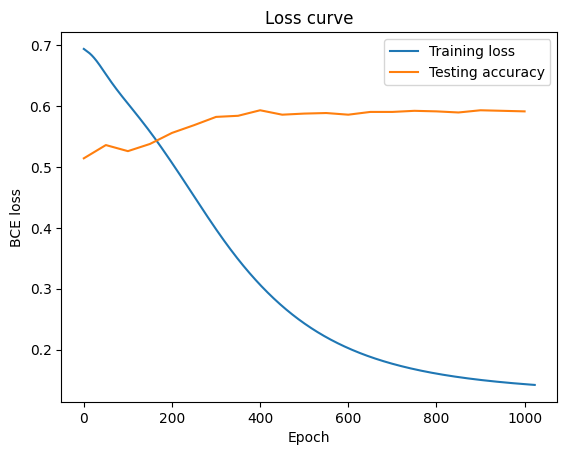

In [387]:
model = Net(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

num_epochs = 1024

training_loss = []
testing_acc = []


for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer.step()

    epoch_loss = loss.item()
    training_loss.append(epoch_loss)

    if epoch % 50 == 0:
        model.eval()
        
        with torch.no_grad():
            y_pred = model(X_test)
            y_hat = (y_pred > 0.5).numpy().astype(int)
            testing_acc.append(accuracy_score(y_test, y_hat))

plt.figure()
plt.plot(range(num_epochs), training_loss)
plt.plot(range(0, num_epochs, 50), testing_acc)
plt.title("Loss curve")
plt.legend(['Training loss', 'Testing accuracy'])
plt.xlabel("Epoch")
plt.ylabel("BCE loss")
plt.savefig(os.path.join(os.getcwd(), "../output/loss_curve.png"))
plt.show()
plt.close()

0.9192926773974156


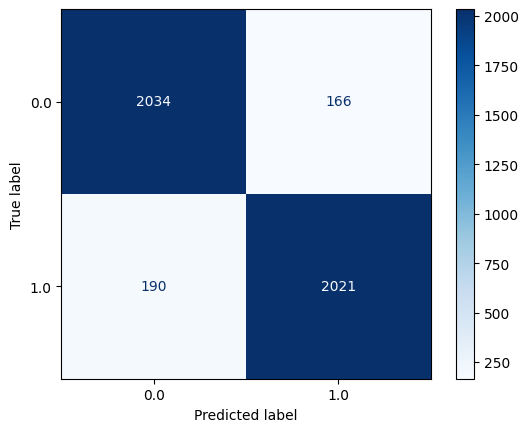

In [388]:
from sklearn.metrics import ConfusionMatrixDisplay

y_hat = (model(X_train).detach().numpy() > 0.5).astype(int)

ConfusionMatrixDisplay.from_predictions(y_train, y_hat, cmap='Blues')

print(accuracy_score(y_train, y_hat))

0.5902085222121487


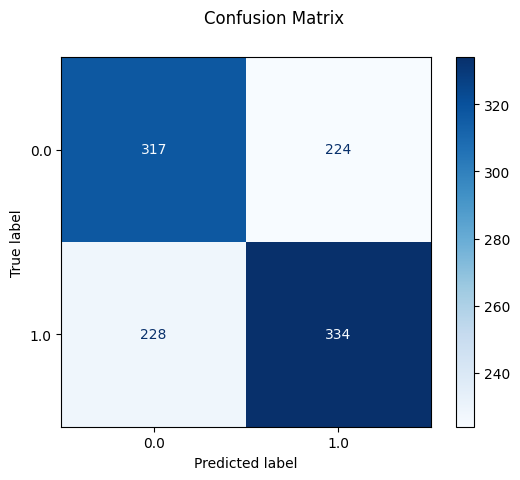

In [389]:
from sklearn.metrics import ConfusionMatrixDisplay

y_hat = (model(X_test).detach().numpy() > 0.5).astype(int)

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_hat, cmap='Blues')
disp.figure_.suptitle("Confusion Matrix")
disp.figure_.savefig(os.path.join(os.getcwd(), "../output/confusion_matrix.png"))

print(accuracy_score(y_test, y_hat))